# Bayesian Belief Polarization

**Inspired by:** _Jern, A., Chang, K. M., & Kemp, C. (2009). [Bayesian belief polarization.](https://proceedings.neurips.cc/paper/2009/file/3435c378bb76d4357324dd7e69f3cd18-Paper.pdf) Advances in neural information processing systems, 22._

Why is it that two people can look at the same data and reach very different conclusions?

Consider two economists, Alice and Bob, who have different beliefs about the optimal economic policy for their government (fiscally conservative or liberal). They are both asked to evaluate a bill that may or may not increase government spending. Then, a study comes out that makes a prediction about the bill's impact on government spending. We will show with a simple memo model that the economists' evaluations opinions of the bill can get further polarized by this new data.

(See Sec 3.4 of Jern et al. for the full details.)

In [1]:
from enum import IntEnum, auto
from memo import memo
import jax.numpy as np

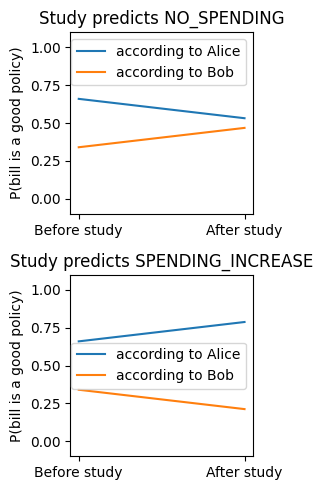

In [2]:
class Opinion_of_Bill(IntEnum):  # is the bill good?
    BAD_POLICY = 0
    GOOD_POLICY = 1

class Bill_Outcome(IntEnum):  # actual effect of bill
    NO_SPENDING = 0
    SPENDING_INCREASE = 1

class Study_Result(IntEnum):  # study conclusion
    NO_SPENDING = 0
    SPENDING_INCREASE = 1

class Optimal_Economic_Policy(IntEnum):  # economic philosophy
    FISCALLY_CONSERVATIVE = 0
    FISCALLY_LIBERAL = 1

class Economist(IntEnum):
    ALICE = 0
    BOB = 1

@memo
def prior[e: Economist]():
    economist: knows(e)
    economist: thinks[
        world: knows(e),
        world: chooses(v1 in Optimal_Economic_Policy, wpp=(
            (0.9 if v1 == {Optimal_Economic_Policy.FISCALLY_LIBERAL} else 0.1)
                if e == {Economist.ALICE} else
            (0.1 if v1 == {Optimal_Economic_Policy.FISCALLY_LIBERAL} else 0.9)
        )),
        world: chooses(v2 in Bill_Outcome, wpp=1),
        world: chooses(d in Study_Result, wpp=0.9 if d == v2 else 0.1),
        world: chooses(h in Opinion_of_Bill, wpp=(
            0.5 if v2 == {Bill_Outcome.NO_SPENDING} else (
                (0.1 if h == {Opinion_of_Bill.GOOD_POLICY} else 0.9)
                    if v1 == {Optimal_Economic_Policy.FISCALLY_CONSERVATIVE} else
                (0.9 if h == {Opinion_of_Bill.GOOD_POLICY} else 0.1)
            )
        ))
    ]
    return economist[Pr[world.h == 1]]

@memo
def posterior[e: Economist, d: Study_Result]():
    economist: knows(e)
    economist: thinks[
        world: knows(e),
        world: chooses(v1 in Optimal_Economic_Policy, wpp=(
            (0.9 if v1 == {Optimal_Economic_Policy.FISCALLY_LIBERAL} else 0.1)
                if e == {Economist.ALICE} else
            (0.1 if v1 == {Optimal_Economic_Policy.FISCALLY_LIBERAL} else 0.9)
        )),
        world: chooses(v2 in Bill_Outcome, wpp=1),
        world: chooses(d in Study_Result, wpp=0.9 if d == v2 else 0.1),
        world: chooses(h in Opinion_of_Bill, wpp=(
            0.5 if v2 == {Bill_Outcome.NO_SPENDING} else (
                (0.1 if h == {Opinion_of_Bill.GOOD_POLICY} else 0.9)
                    if v1 == {Optimal_Economic_Policy.FISCALLY_CONSERVATIVE} else
                (0.9 if h == {Opinion_of_Bill.GOOD_POLICY} else 0.1)
            )
        ))
    ]
    economist: observes [world.d] is d
    return economist[Pr[world.h == 1]]

from matplotlib import pyplot as plt

plt.figure(figsize=(3, 5))
for i, d in enumerate(Study_Result):
    plt.subplot(2, 1, i + 1)
    plt.plot(np.stack([prior(), posterior()[:, d]]), label=['according to Alice', 'according to Bob'])
    plt.ylim(-0.1, 1.1)
    plt.ylabel('P(bill is a good policy)')
    plt.xticks([0, 1], ['Before study', 'After study'])
    plt.title(f'Study predicts {d.name}')
    plt.legend()
plt.tight_layout()